In [1]:
# this function generates an item bank, in case the user cannot provide one
from catsim.cat import generate_item_bank
# simulation package contains the Simulator and all abstract classes
from catsim.simulation import *
# initialization package contains different initial proficiency estimation strategies
from catsim.initialization import *
# selection package contains different item selection strategies
from catsim.selection import *
# estimation package contains different proficiency estimation methods
from catsim.estimation import *
# stopping package contains different stopping criteria for the CAT
from catsim.stopping import *
import catsim.plot as catplot
from catsim.irt import icc

import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean

import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
import gym
import random
from random import randint

from gym import Env, spaces
import time

from IPython import display


# hyperparameters
# parâmetros da rede neural
hidden_size = 128
learning_rate = 3e-4

# Constants
# parâmetros da simulação
GAMMA = 0.99
num_steps = 1000
max_episodes = 100
max_numQ = 40



# nn.Module: import torch.nn as nn
# class tem hierarquia
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 1)

        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, num_actions)
    
    def forward(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        value = F.relu(self.critic_linear1(state))
        value = self.critic_linear2(value)
        
        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = F.softmax(self.actor_linear2(policy_dist), dim=1)

        return value, policy_dist


def a2c(env):
    num_inputs = env.observation_space.shape[0]

    print(num_inputs)

    num_outputs = env.action_space.n
    
    # ActorCritic: olhar __init__
    actor_critic = ActorCritic(num_inputs, num_outputs, hidden_size)
    ac_optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)

    all_lengths = []
    average_lengths = []
    all_rewards = []
    entropy_term = 0

    for episode in range(max_episodes):
        log_probs = []
        values = []
        rewards = []

        state = env.reset()
        for steps in range(num_steps):
            value, policy_dist = actor_critic.forward(state)
            value = value.detach().numpy()[0,0]
            dist = policy_dist.detach().numpy() 

            action = np.random.choice(num_outputs, p=np.squeeze(dist))
            log_prob = torch.log(policy_dist.squeeze(0)[action])
            entropy = -np.sum(np.mean(dist) * np.log(dist))
            new_state, reward, done, _ = env.step(action)

            rewards.append(reward)
            values.append(value)
            log_probs.append(log_prob)
            entropy_term += entropy
            state = new_state
            
            if done or steps == num_steps-1:
                Qval, _ = actor_critic.forward(new_state)
                Qval = Qval.detach().numpy()[0,0]
                all_rewards.append(np.sum(rewards))
                all_lengths.append(steps)
                average_lengths.append(np.mean(all_lengths[-10:]))
                #if episode % 10 == 0:                    
                    #sys.stdout.write("episode: {}, reward: {}, total length: {}, average length: {} \n".format(episode, np.sum(rewards), steps, average_lengths[-1]))
                break
        
        # compute Q values
        Qvals = np.zeros_like(values)
        for t in reversed(range(len(rewards))):
            Qval = rewards[t] + GAMMA * Qval
            Qvals[t] = Qval
  
        #update actor critic
        values = torch.FloatTensor(values)
        Qvals = torch.FloatTensor(Qvals)
        log_probs = torch.stack(log_probs)
        
        advantage = Qvals - values
        actor_loss = (-log_probs * advantage).mean()
        critic_loss = 0.5 * advantage.pow(2).mean()
        ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

        ac_optimizer.zero_grad()
        ac_loss.backward()
        ac_optimizer.step()
 
    
    # Plot results
    print(mean(all_rewards))
    smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
    smoothed_rewards = [elem for elem in smoothed_rewards]
    plt.plot(all_rewards)
    plt.plot(smoothed_rewards)
    plt.plot()
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

    plt.plot(all_lengths)
    plt.plot(average_lengths)
    plt.xlabel('Episode')
    plt.ylabel('Episode length')
    plt.show()


class CATGYM(Env):
    def __init__(self):
        super(CATGYM, self).__init__()
        self.alunos = pd.read_excel('C:/Users/patri/Desktop/Base_enem/enem.xlsx')
        self.param = pd.read_excel('C:/Users/patri/Desktop/Base_enem/parametros.xlsx')
        self.items = self.param.iloc[0:45,1:5].to_numpy()

        self.observation_shape = (3,1)
        
        self.observation_space = spaces.Box(low = np.array([-4,0,0]),
                                            high = np.array([+4,1,20]),
                                            dtype = np.float16)


        # Define an action space ranging from 0 to 4
        # porque definimos esse espaço no GYM: 3 ações discretas
        self.action_space = spaces.Discrete(3,)
        
        self.mu = -4
        self.sigma = 0
        self.nq = 0

    def reset(self):
        
        self.aluno = randint(0,9999)
        
        self.responses = []
        self.administered_items = []
        
        self.initializer = RandomInitializer()
        self.selector0 = selector
        self.selector1 = RandomSelector()
        self.estimator = NumericalSearchEstimator()
        # self.stopper = MaxItemStopper(20)

        self.est_theta = self.initializer.initialize()
        
        full_items = list(range(0, 45))
        respostas = self.alunos.iloc[self.aluno,0:45].tolist()
        self.ori_theta = self.estimator.estimate(items=self.items, administered_items=full_items, response_vector=respostas, est_theta=self.est_theta)
        #print('Theta Original: ',self.ori_theta)

        # Determine a place to intialise
        self.mu = 0
        self.sigma = 0
        self.nq = 0

        return np.array([self.mu,self.sigma,self.nq])


    def step(self, action):
        action_continue = True

        if action == 0:
            item_index = self.selector0.select(items=self.items, administered_items=self.administered_items, est_theta=self.est_theta)
        elif action == 1:
            item_index = self.selector1.select(items=self.items, administered_items=self.administered_items, est_theta=self.est_theta)
        elif action == 2:
            if self.nq > 0:
                action_continue = False
            else:
                item_index = self.selector1.select(items=self.items, administered_items=self.administered_items, est_theta=self.est_theta)


        if action_continue:
            #a, b, c, d = self.items[item_index]
            #prob = icc(self.ori_theta, a, b, c, d)
            #correct = numpy.random.uniform() < prob
            correct = self.alunos.iloc[self.aluno,item_index]
            self.administered_items.append(item_index)
            self.responses.append(correct)
            

        self.est_theta = self.estimator.estimate(items=self.items, administered_items=self.administered_items, response_vector=self.responses, est_theta=self.est_theta)
        #print('Estimated proficiency, given answered items:', self.est_theta)

        reward = -abs(self.ori_theta - self.est_theta)


        # Flag that marks the termination of an episode
        done = False
        
        # Assert that it is a valid action 
        assert self.action_space.contains(action), "Invalid Action"

        self.nq = self.nq+1

        if self.nq >= max_numQ or not action_continue:
            done = True
            # print(len(self.administered_items))
        else:    
            reward = 0

        # Increment the episodic return
        #self.ep_return += reward
        self.mu = self.est_theta
        self.mu = 0
        self.sigma = 0
        return np.array([self.mu,self.sigma,self.nq]), reward, done, []

C:\Users\patri\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


C:\Users\patri\Anaconda3\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


3


C:\Users\patri\Anaconda3\lib\site-packages\catsim\selection.py:73: UserWarning: This selector needs an item matrix with at least 5 columns, with the last one representing item exposure rate. Since this column is absent, it will presume all items have exposure rates = 0
  "This selector needs an item matrix with at least 5 columns, with the last one representing item exposure rate. Since this column is absent, it will presume all items have exposure rates = 0"


-1.6459115761241165


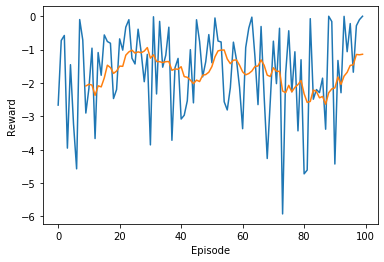

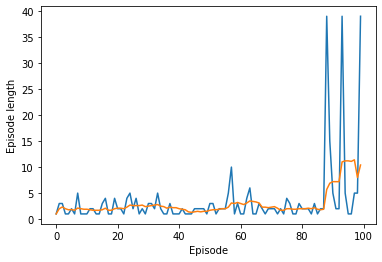

In [2]:
selector = MaxInfoSelector()
if __name__ == "__main__":
    env = CATGYM()
    a2c(env)

3
-1.2208856529872922


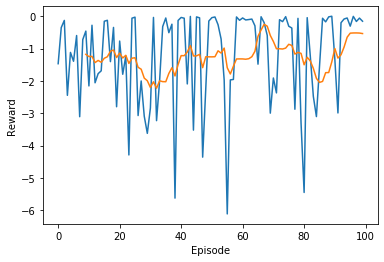

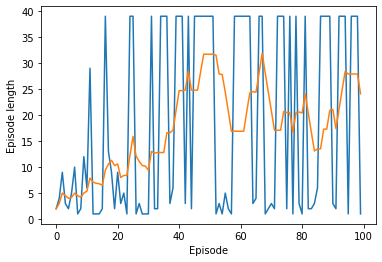

In [51]:
selector = IntervalInfoSelector()
if __name__ == "__main__":
    env = CATGYM()
    a2c(env)

3
-1.5209952425350557


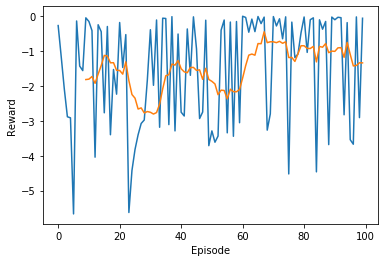

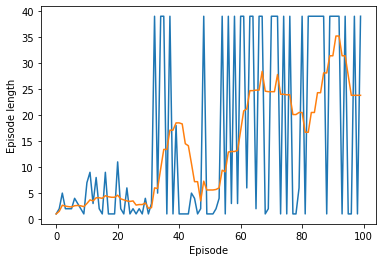

In [26]:
selector = RandomSelector()
if __name__ == "__main__":
    env = CATGYM()
    a2c(env)

3
-1.4316134472597923


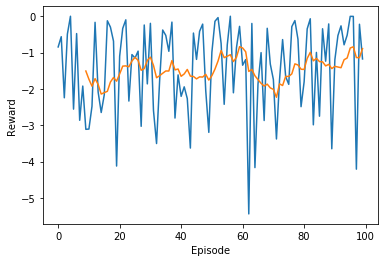

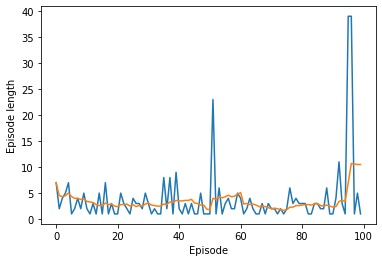

In [30]:
selector = UrrySelector()
if __name__ == "__main__":
    env = CATGYM()
    a2c(env)

3
-1.262438226093999


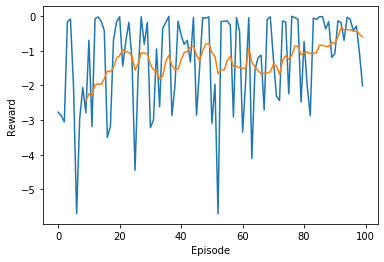

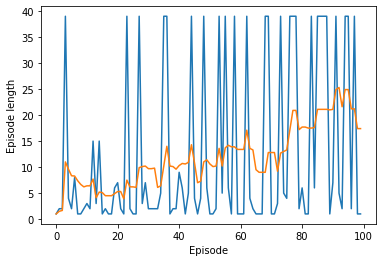

In [44]:
selector = The54321Selector(44)
if __name__ == "__main__":
    env = CATGYM()
    a2c(env)

In [ ]:
import numpy as np

msk = np.random.rand(len(df)) < 0.8 # cria uma mascara com as posicoes
train = df[msk]
test = df[~msk]